# Exercises
The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is `curriculum_logs`.

**Hint**: You will need to explore the database and significantly adjust your acquisition step (yay SQL!)

1. Label students by the program they are in.
1. Is it possible to identify the user_id of a staff member?
1. Identify students who are accessing our curriculum pages beyond the end of their time at Codeup.
1. Identify students who present anomalous activity using the Bollinger Band method, but reduce K to 2. 
1. Plot the access activity of these students.

**BONUS:** Identify users who are viewing both the web dev and data science curriculum 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import env

In [23]:
# saving url string to access sequel ace curriculum logs db
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'

# saving query to access corhorts and logs tables
query_cohorts = '''
SELECT  id as cohortid_cohorts,
        start_date,
        end_date,
        name as cohortname,
        program_id
FROM cohorts
'''

query_logs = '''
SELECT *
FROM logs
'''

In [24]:
# reading cohorts query to df
df_cohorts = pd.read_sql(query_cohorts, url)
df_cohorts.head()

,cohortid_cohorts,start_date,end_date,cohortname,program_id
0,1,2014-02-04,2014-04-22,Arches,1
1,2,2014-06-04,2014-08-22,Badlands,1
2,3,2014-09-04,2014-11-05,Carlsbad,1
3,4,2014-10-20,2015-01-18,Denali,1
4,5,2014-11-18,2015-02-24,Everglades,1


In [4]:
# reading logs query to df
df_logs = pd.read_sql(query_logs, url)
df_logs.head()

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [25]:
# print statements for size of each df
print(f'The cohorts df has {df_cohorts.shape[0]} rows and {df_cohorts.shape[1]} columns.')
print(f'The logs df has {df_logs.shape[0]} rows and {df_logs.shape[1]} columns.')

The cohorts df has 53 rows and 5 columns.
The logs df has 900223 rows and 6 columns.


In [27]:
for df in [df_cohorts, df_logs]:
    for col in df.columns:
        print(col)
        print(f'The {col} column has {df[col].nunique()} unique values.')
        print(f'Dtype: {df[col].dtype}')
        print()

cohortid_cohorts
The cohortid_cohorts column has 53 unique values.
Dtype: int64

start_date
The start_date column has 49 unique values.
Dtype: object

end_date
The end_date column has 50 unique values.
Dtype: object

cohortname
The cohortname column has 53 unique values.
Dtype: object

program_id
The program_id column has 4 unique values.
Dtype: int64

date
The date column has 1182 unique values.
Dtype: object

time
The time column has 73167 unique values.
Dtype: object

path
The path column has 2313 unique values.
Dtype: object

user_id
The user_id column has 981 unique values.
Dtype: int64

cohort_id
The cohort_id column has 47 unique values.
Dtype: float64

ip
The ip column has 5531 unique values.
Dtype: object



In [28]:
# joining the dfs with merge on cohort id, dropping duplicate float column
df = df_cohorts.merge(df_logs, left_on = 'cohortid_cohorts', right_on = 'cohort_id')\
                                            .drop(columns = 'cohort_id')

df.head()

,cohortid_cohorts,start_date,end_date,cohortname,program_id,date,time,path,user_id,ip
0,1,2014-02-04,2014-04-22,Arches,1,2018-01-26,10:14:47,/,11,97.105.19.61
1,1,2014-02-04,2014-04-22,Arches,1,2018-01-26,10:14:51,javascript-i,11,97.105.19.61
2,1,2014-02-04,2014-04-22,Arches,1,2018-01-26,10:15:02,javascript-i/functions,11,97.105.19.61
3,1,2014-02-04,2014-04-22,Arches,1,2018-01-26,11:46:29,appendix/further-reading/javascript/hoisting.html,11,97.105.19.61
4,1,2014-02-04,2014-04-22,Arches,1,2018-01-26,11:46:39,appendix,11,97.105.19.61


## 1. Label students by program they are in

In [32]:
# creating a crosstab of all the cohorts and the cohort ids so I can add labels for 1, 2, 3, and 3
pd.crosstab(df.cohortname, df.program_id).head(7)

program_id,1,2,3,4
cohortname,,,,
Andromeda,0,25359,0,0
Apex,0,33568,0,0
Apollo,0,0,0,5
Arches,8890,0,0,0
Badlands,93,0,0,0
Bash,0,17713,0,0
Bayes,0,0,26538,0


### Program IDs
`1`: **PHP** | `Arches`<br>
`2`: **JAVA** | `Andromeda`<br>
`3`: **DS** | `Bayes`<br>
`4`: **Front End** | `Apollo`<br>

In [35]:
df['program'] = df.program_id.map({1: 'PHP', 2: 'JAVA', 3: 'DS', 4: 'FRONT END'})
df.head()

,cohortid_cohorts,start_date,end_date,cohortname,program_id,date,time,path,user_id,ip,program
0,1,2014-02-04,2014-04-22,Arches,1,2018-01-26,10:14:47,/,11,97.105.19.61,PHP
1,1,2014-02-04,2014-04-22,Arches,1,2018-01-26,10:14:51,javascript-i,11,97.105.19.61,PHP
2,1,2014-02-04,2014-04-22,Arches,1,2018-01-26,10:15:02,javascript-i/functions,11,97.105.19.61,PHP
3,1,2014-02-04,2014-04-22,Arches,1,2018-01-26,11:46:29,appendix/further-reading/javascript/hoisting.html,11,97.105.19.61,PHP
4,1,2014-02-04,2014-04-22,Arches,1,2018-01-26,11:46:39,appendix,11,97.105.19.61,PHP


In [36]:
df.program.value_counts()

JAVA         713365
DS           103412
PHP           30548
FRONT END         5
Name: program, dtype: int64

## 2. Is it possible to identify the `user_id` of a staff member?

In [37]:
# wondering if something could be in the cohort names, looking at each unique value
df.cohortname.unique()

array(['Arches', 'Badlands', 'Denali', 'Everglades', 'Franklin',
       'Glacier', 'Hampton', 'Apollo', 'Ike', 'Joshua', 'Kings', 'Lassen',
       'Mammoth', 'Niagara', 'Olympic', 'Pinnacles', 'Quincy', 'Sequoia',
       'Teddy', 'Ulysses', 'Voyageurs', 'Wrangell', 'Xanadu', 'Yosemite',
       'Staff', 'Zion', 'Andromeda', 'Betelgeuse', 'Ceres', 'Bayes',
       'Deimos', 'Europa', 'Fortuna', 'Curie', 'Apex', 'Ganymede',
       'Hyperion', 'Darden', 'Bash', 'Jupiter', 'Kalypso', 'Easley',
       'Luna', 'Marco', 'Florence', 'Neptune', 'Oberon'], dtype=object)

In [39]:
# filtering the data to return only df of staff members
df_staff = df[df.cohortname == 'Staff']
df_staff.head()

,cohortid_cohorts,start_date,end_date,cohortname,program_id,date,time,path,user_id,ip,program
210775,28,2014-02-04,2014-02-04,Staff,2,2018-12-06,14:15:29,appendix/further-reading/java/intellij-tomcat-...,53,97.105.19.58,JAVA
210776,28,2014-02-04,2014-02-04,Staff,2,2018-12-06,14:25:40,javascript-i,314,97.105.19.58,JAVA
210777,28,2014-02-04,2014-02-04,Staff,2,2018-12-06,14:25:41,javascript-i/coffee-project,314,97.105.19.58,JAVA
210778,28,2014-02-04,2014-02-04,Staff,2,2018-12-06,15:31:29,spring,40,170.248.173.247,JAVA
210779,28,2014-02-04,2014-02-04,Staff,2,2018-12-06,15:31:33,spring/fundamentals/security,40,170.248.173.247,JAVA


## 3. Identify students who are accessing curriculum after their time at Codeup.

In [42]:
# boolean mask for end dates that are less than access dates
df[df.end_date < df.date]

,cohortid_cohorts,start_date,end_date,cohortname,program_id,date,time,path,user_id,ip,program
0,1,2014-02-04,2014-04-22,Arches,1,2018-01-26,10:14:47,/,11,97.105.19.61,PHP
1,1,2014-02-04,2014-04-22,Arches,1,2018-01-26,10:14:51,javascript-i,11,97.105.19.61,PHP
2,1,2014-02-04,2014-04-22,Arches,1,2018-01-26,10:15:02,javascript-i/functions,11,97.105.19.61,PHP
3,1,2014-02-04,2014-04-22,Arches,1,2018-01-26,11:46:29,appendix/further-reading/javascript/hoisting.html,11,97.105.19.61,PHP
4,1,2014-02-04,2014-04-22,Arches,1,2018-01-26,11:46:39,appendix,11,97.105.19.61,PHP
...,...,...,...,...,...,...,...,...,...,...,...
758389,62,2020-09-21,2021-03-30,Jupiter,2,2021-04-20,20:39:56,spring/setup,773,70.121.201.159,JAVA
758390,62,2020-09-21,2021-03-30,Jupiter,2,2021-04-21,09:42:38,/,756,108.95.37.118,JAVA
758391,62,2020-09-21,2021-03-30,Jupiter,2,2021-04-21,09:42:40,search/search_index.json,756,108.95.37.118,JAVA
758392,62,2020-09-21,2021-03-30,Jupiter,2,2021-04-21,09:42:44,javascript-ii/RESTful-api,756,108.95.37.118,JAVA


In [57]:
# using .unique() function with the user_id series, to return list of all users who fit above criterion
df[df.end_date < df.date].user_id.unique()

array([ 11,  60,  64,  95, 141, 146, 148, 170, 209, 211, 212, 248, 257,
       312, 313, 316, 398, 402, 144, 280, 396,  85, 649, 283, 405,  77,
       169, 173,  88, 348, 513,   1, 114, 150, 174, 646, 152, 177, 245,
       279, 463, 101, 161, 214, 740,  50,  51,  66,  68,  93, 113, 156,
       167, 118, 318,  53,  69,  80,  82,  90,  98, 139, 147, 149, 246,
       593, 647, 852,  72, 107, 164, 172, 427,  21,  40,  97, 143, 165,
       181, 216, 322, 102, 106, 140, 151, 168, 210, 241, 242, 281, 314,
       462, 465, 419, 952,  26,  67,  76,  81,  83,  84,  91, 104, 108,
       162, 178, 179, 217, 611,  37,  70,  71,  75,  87,  92,  94,  96,
       105, 109, 112, 163, 311, 399, 428, 486, 610,  16,  42,  41,  17,
        22,  15,  47,  57,  10,  28,  65,  52,  33,  56,  27,  38,  36,
       110, 115, 153, 175, 255, 286, 346,  29,  19, 180,   6,  99,  43,
        31,   7, 138,  35, 142,   5, 155, 154,  18,   3,  20,  12, 254,
        14, 284, 459,  13, 131, 135, 128, 127, 124, 130, 159, 14

## 4. Bollinger Band Method
Identify students who present anomalous activity using the Bollinger Band method, but reduce K to 2.

In [64]:
# changing date col dtype to datetime
df.date = pd.to_datetime(df.date)

# setting index to date column
df.set_index(df.date, inplace = True)

# preview df
df.head()

,cohortid_cohorts,start_date,end_date,cohortname,program_id,date,time,path,user_id,ip,program
date,,,,,,,,,,,
2018-01-26,1,2014-02-04,2014-04-22,Arches,1,2018-01-26,10:14:47,/,11,97.105.19.61,PHP
2018-01-26,1,2014-02-04,2014-04-22,Arches,1,2018-01-26,10:14:51,javascript-i,11,97.105.19.61,PHP
2018-01-26,1,2014-02-04,2014-04-22,Arches,1,2018-01-26,10:15:02,javascript-i/functions,11,97.105.19.61,PHP
2018-01-26,1,2014-02-04,2014-04-22,Arches,1,2018-01-26,11:46:29,appendix/further-reading/javascript/hoisting.html,11,97.105.19.61,PHP
2018-01-26,1,2014-02-04,2014-04-22,Arches,1,2018-01-26,11:46:39,appendix,11,97.105.19.61,PHP


In [67]:
# resampling data to look at observations by day
path = df.path.resample('d').count()
path.head()

date
2018-01-26    533
2018-01-27    230
2018-01-28    168
2018-01-29    783
2018-01-30    614
Freq: D, Name: path, dtype: int64

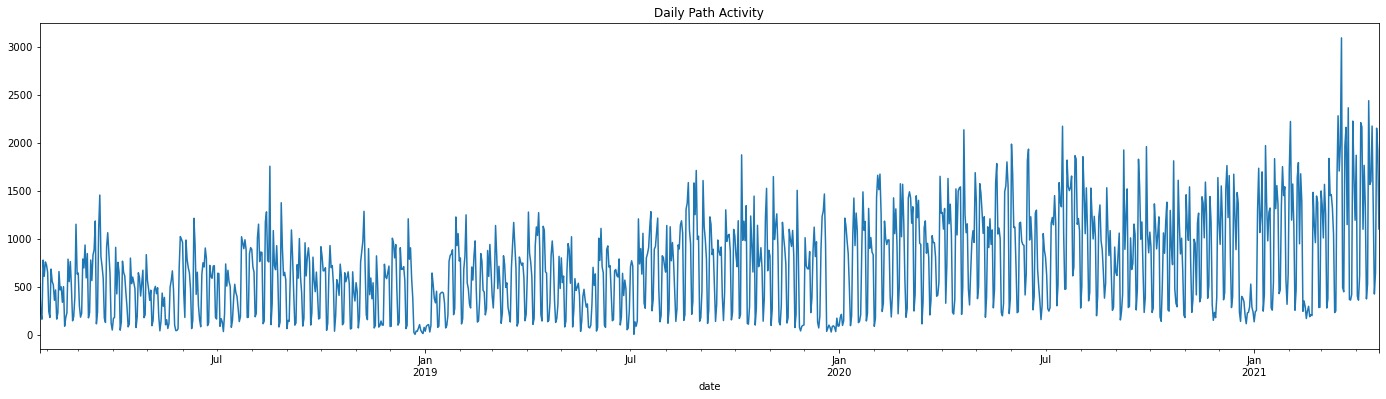

In [72]:
# plotting daily activity
path.plot(figsize = (24, 6))
plt.title('Daily Path Activity')
plt.show()

In [73]:
# setting the window span
span = 30

# calculating midband
midband = path.ewm(span = span).mean()
midband.head()

date
2018-01-26    533.000000
2018-01-27    376.450000
2018-01-28    302.284709
2018-01-29    434.739290
2018-01-30    475.525441
Freq: D, Name: path, dtype: float64

In [74]:
# calculating exponential std dev
stdev = path.ewm(span = span).std()
stdev.head()

date
2018-01-26           NaN
2018-01-27    214.253355
2018-01-28    192.738756
2018-01-29    292.489456
2018-01-30    262.780177
Freq: D, Name: path, dtype: float64

In [78]:
K = 2

# calculating upper, lower bands, and zero band (lowest logical value)
ub = midband + (stdev * K)
lb = midband - (stdev * K)
zb = 0

ub, lb, zb

(date
 2018-01-26            NaN
 2018-01-27     804.956709
 2018-01-28     687.762221
 2018-01-29    1019.718202
 2018-01-30    1001.085795
                  ...     
 2021-04-17    2797.621100
 2021-04-18    2743.915056
 2021-04-19    2819.783757
 2021-04-20    2839.229086
 2021-04-21    2780.075594
 Freq: D, Name: path, Length: 1182, dtype: float64,
 date
 2018-01-26           NaN
 2018-01-27    -52.056709
 2018-01-28    -83.192803
 2018-01-29   -150.239623
 2018-01-30    -50.034912
                  ...    
 2021-04-17   -170.183548
 2021-04-18   -201.989605
 2021-04-19   -163.659948
 2021-04-20   -106.597135
 2021-04-21    -80.903769
 Freq: D, Name: path, Length: 1182, dtype: float64,
 0)

In [82]:
# concatenating ub, midband, lb
my_df = pd.concat([ub, midband, lb], axis = 1)
my_df.head()

,path,path,path
date,,,
2018-01-26,NaN,533.000000,NaN
2018-01-27,804.956709,376.450000,-52.056709
2018-01-28,687.762221,302.284709,-83.192803
2018-01-29,1019.718202,434.739290,-150.239623
2018-01-30,1001.085795,475.525441,-50.034912


In [84]:
# changing col names
my_df.columns = ['ub', 'mb', 'lb']
my_df.head()

,ub,mb,lb
date,,,
2018-01-26,NaN,533.000000,NaN
2018-01-27,804.956709,376.450000,-52.056709
2018-01-28,687.762221,302.284709,-83.192803
2018-01-29,1019.718202,434.739290,-150.239623
2018-01-30,1001.085795,475.525441,-50.034912


In [91]:
# concatenating path with bands df
bands_df = pd.concat([path, my_df], axis = 1).rename(columns = {0:'path'})

# adding zero band colummn
bands_df['zb'] = zb

# preview
bands_df.head()

,path,ub,mb,lb,zb
date,,,,,
2018-01-26,533,NaN,533.000000,NaN,0
2018-01-27,230,804.956709,376.450000,-52.056709,0
2018-01-28,168,687.762221,302.284709,-83.192803,0
2018-01-29,783,1019.718202,434.739290,-150.239623,0
2018-01-30,614,1001.085795,475.525441,-50.034912,0


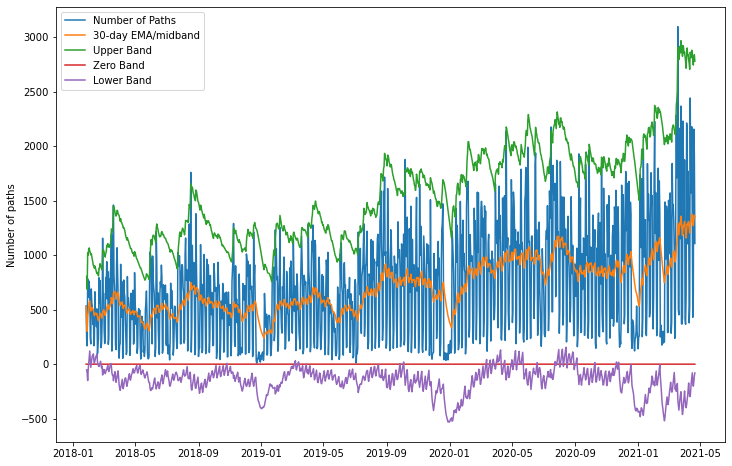

In [92]:
# plotting the bands
fig, ax = plt.subplots(figsize = (12, 8))

ax.plot(bands_df.index, bands_df.path, label = 'Number of Paths')

ax.plot(bands_df.index, bands_df.mb, label = '30-day EMA/midband')
ax.plot(bands_df.index, bands_df.ub, label = 'Upper Band')
ax.plot(bands_df.index, bands_df.zb, label = 'Zero Band')
ax.plot(bands_df.index, bands_df.lb, label = 'Lower Band')

ax.legend(loc = 'best')
ax.set_ylabel('Number of paths')

plt.show()